## Keras Imports

In [1]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

# set seeds for reproducability
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(2)
seed(1)

Using TensorFlow backend.


## Other Imports 

In [2]:
import pickle
import pandas as pd
import numpy as np
import string, os 
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
from collections import Counter
import sys
import json
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import StratifiedShuffleSplit

import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

## Reading Lyrics file

In [3]:
data_location = 's3://clean-tbd-databucket/clean_eval_final.csv.csv'
#data_location='s3://clean-tbd-databucket/clean_training_batch_9.csv.csv'
lyric_df=pd.read_csv(data_location)

## Get data ready for evaluation

In [4]:
genre_set={'Country','Electronic','Folk','Hip-Hop','Indie','Jazz','Metal','Pop','R&B','Rock'}

In [5]:
df_genre=set(lyric_df.genre)

In [6]:
genre_diff=genre_set-df_genre

In [7]:
lyric_df = pd.concat([lyric_df,pd.get_dummies(lyric_df['genre'], prefix='genre')],axis=1)


In [8]:
for genre in list(genre_diff):
    lyric_df['genre_'+genre] = 0

In [9]:
lyric_df.head()

,Unnamed: 0,genre,song,clean_lyrics,clean_song,language,clean_lyrics_last_3,lyrics,lyrics_last_3,Hillarylyrics,...,genre_Country,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Metal,genre_Pop,genre_R&B,genre_Rock
0,0,Rock,nave de prata,ela pode estar perto entre o dia e a noite tud...,nave de prata,Not_English,ao avesso ela,ELA PODE ESTAR PERTO ENTRE O DIA E A NOITE TUD...,AO AVESSO ELA,ela pode estar perto entre o dia e a noite tud...,...,0,0,0,0,0,0,0,0,0,1
1,1,Rock,no trem do amor,o coração mandar deve ser tão bom viver de amo...,no trem do amor,Not_English,por onde for,o coração mandar Deve ser tão bom viver de amo...,por onde for,o coração mandar deve ser tão bom viver de amo...,...,0,0,0,0,0,0,0,0,0,1
2,2,Pop,stay together,we gotta stay together jami ojil anha neodo na...,stay together,English,bomyeon na tteollyeo,we gotta stay together Jami ojil anha neodo na...,bomyeon na tteollyeo,we gotta stay together jami ojil anha neodo na...,...,0,0,0,0,0,0,0,1,0,0
3,3,Pop,the baddest female,dle eun unni ra bool leo yo pak pak jal na ga ...,the baddest female,English,meo ri yes,dle eun unni ra bool leo yo Pak pak jal na ga ...,meo ri Yes,dle eun unni ra bool leo yo pak pak jal na ga ...,...,0,0,0,0,0,0,0,1,0,0
4,5,Rock,jackolantern's weather,though we dont have too long to love a day a n...,jackolanterns weather,English,i was malcontented,Though we dont have too long to love a day a n...,I was malcontented,though we dont have too long to love a day a n...,...,0,0,0,0,0,0,0,0,0,1


In [10]:
def eval_lyric(liststr):
    try:
        return eval(liststr)
    except:
        return []

lyric_df['Hillary100words'] = lyric_df['Hillary100words'].apply(eval_lyric)
lyric_df['hillarylength'] = lyric_df['Hillary100words'].apply(lambda x: len(x))


In [11]:
lyricdf = lyric_df[lyric_df['hillarylength'] == 100]
lyricdf = lyricdf.drop(['hillarylength'],axis = 1)

In [12]:
def generate_modelling_file(words):
    index = []
    for word in words:
        try:
            if lyric_tokenizer[word] > len(embedding_matrix) - 1:
                index.append( len(embedding_matrix) - 1)
            else:
                index.append(lyric_tokenizer[word])
        except:
            index.append( len(embedding_matrix) - 1)
            
    
    return embedding_matrix[index,:]

In [13]:
def create_label(row):
    dependent_labels = [
        'genre_Country','genre_Electronic','genre_Folk','genre_Hip-Hop',
        'genre_Indie','genre_Jazz','genre_Metal','genre_Pop','genre_R&B',
        'genre_Rock'
    ]

    return np.array(row[dependent_labels])


## Model Creation

In [14]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [15]:
with open("lyric_tokenizer.json", "r") as f:
    lyric_tokenizer = json.load(f)
    print("loading lyric_tokenizer file to lyric_tokenizer.json")

loading lyric_tokenizer file to lyric_tokenizer.json


In [16]:
embedding_matrix = np.zeros((len(embeddings_index), 100))
cnt = 0
for word, i in lyric_tokenizer.items():
    if cnt > len(embeddings_index) - 1:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
         embedding_matrix[i] = embedding_vector
    cnt += 1

In [17]:
max_sequence_len = 100
embedding_dimension = 100
total_words = np.shape(embedding_matrix)[0]
print (total_words)
NumberGenres = 10

400000


In [18]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len 
    model = Sequential()
    
    # Add Input Embedding Layer
   # model.add(Embedding(total_words, embedding_dimension, 
   #                     weights = [embedding_matrix], input_length=input_len, trainable = False))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100, input_shape=(100,100)))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(NumberGenres, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 81,410
Trainable params: 81,410
Non-trainable params: 0
_________________________________________________________________


In [19]:
lyricdf['X'] = lyricdf['Hillary100words'].apply(generate_modelling_file)

In [20]:
create_label(lyricdf.head().iloc[0,:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=object)

In [21]:
a = lyricdf.apply(lambda row: create_label(row), axis = 1)

In [22]:
lyricdf.head()

,Unnamed: 0,genre,song,clean_lyrics,clean_song,language,clean_lyrics_last_3,lyrics,lyrics_last_3,Hillarylyrics,...,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Metal,genre_Pop,genre_R&B,genre_Rock,X
0,0,Rock,nave de prata,ela pode estar perto entre o dia e a noite tud...,nave de prata,Not_English,ao avesso ela,ELA PODE ESTAR PERTO ENTRE O DIA E A NOITE TUD...,AO AVESSO ELA,ela pode estar perto entre o dia e a noite tud...,...,0,0,0,0,0,0,0,0,1,"[[0.3753199875354767, -0.4867599904537201, 0.0..."
1,1,Rock,no trem do amor,o coração mandar deve ser tão bom viver de amo...,no trem do amor,Not_English,por onde for,o coração mandar Deve ser tão bom viver de amo...,por onde for,o coração mandar deve ser tão bom viver de amo...,...,0,0,0,0,0,0,0,0,1,"[[-0.26065999269485474, -0.022260000929236412,..."
2,2,Pop,stay together,we gotta stay together jami ojil anha neodo na...,stay together,English,bomyeon na tteollyeo,we gotta stay together Jami ojil anha neodo na...,bomyeon na tteollyeo,we gotta stay together jami ojil anha neodo na...,...,0,0,0,0,0,0,1,0,0,"[[-0.1779100000858307, 0.6267499923706055, 0.4..."
3,3,Pop,the baddest female,dle eun unni ra bool leo yo pak pak jal na ga ...,the baddest female,English,meo ri yes,dle eun unni ra bool leo yo Pak pak jal na ga ...,meo ri Yes,dle eun unni ra bool leo yo pak pak jal na ga ...,...,0,0,0,0,0,0,1,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,5,Rock,jackolantern's weather,though we dont have too long to love a day a n...,jackolanterns weather,English,i was malcontented,Though we dont have too long to love a day a n...,I was malcontented,though we dont have too long to love a day a n...,...,0,0,0,0,0,0,0,0,1,"[[-0.20047999918460846, 0.39649999141693115, 0..."


In [23]:
lyricdf['Y_out'] = a

In [24]:
lyricdf['Y_out'] = lyricdf.apply(lambda row: create_label(row), axis = 1)

## Load Model Weights

In [25]:
model.load_weights("newmodel.h5")
print("Loaded model from disk")
 

Loaded model from disk


In [26]:
x_test = np.array(lyricdf['X'].tolist())
y_test = np.array(lyricdf['Y_out'].tolist())


In [27]:
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Scoring the Model

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

acc: 50.50%


In [29]:
genre_list = ['genre_Country','genre_Electronic','genre_Folk','genre_Hip-Hop',
 'genre_Indie','genre_Jazz','genre_Metal','genre_Pop','genre_R&B',
 'genre_Rock']


## Generating Genre level Metrics

In [30]:
y_test_pred = model.predict(x_test)

In [31]:
perf_dict = dict()
for genre in genre_list:
    perf_dict[genre] = [0,0]
    

In [32]:
for ind in range(0, len(y_test_pred)):
    perf_dict[genre_list[np.argmax(y_test[ind,:])]][1] += 1
    if np.argmax(y_test_pred[ind,:]) == np.argmax(y_test[ind,:]):
         perf_dict[genre_list[np.argmax(y_test[ind,:])]][0] += 1 
        
print ('perf_dict', perf_dict)        


perf_dict {'genre_Country': [26, 60], 'genre_Electronic': [1, 34], 'genre_Folk': [0, 12], 'genre_Hip-Hop': [65, 80], 'genre_Indie': [0, 13], 'genre_Jazz': [13, 61], 'genre_Metal': [37, 66], 'genre_Pop': [33, 207], 'genre_R&B': [0, 11], 'genre_Rock': [334, 464]}


In [33]:
num = 0
den = 0
for key in perf_dict.keys():
    num += perf_dict[key][0]
    den += perf_dict[key][1]
print ('total correctly predicted', num)
print ('total dataset size', den)
print (num/den)

total correctly predicted 509
total dataset size 1008
0.5049603174603174


In [34]:
y_test_pred_prob=model.predict_proba(x_test)

## Model Accuracy Vizzes

In [35]:
from keras.utils import plot_model
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [36]:
Y_pred_classes = np.argmax(y_test_pred,axis = 1) 
Y_pred_probs = np.argmax(y_test_pred_prob,axis=1)
Y_true = np.argmax(y_test,axis = 1) 

In [37]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [38]:
df_confusion = pd.crosstab(Y_true, Y_pred_classes, 
               rownames=['Actual'], colnames=['Predicted'], 
               margins=True).rename(columns={0: "Country", 1: "Electronic", 2:"Folk", 3:"Hip-Hop", 
                                            4:"Indie",5:"Jazz", 6:"Metal",7:"Pop",8:"R&B",9:"Rock"})
df_confusion

Predicted,Country,Electronic,Folk,Hip-Hop,Jazz,Metal,Pop,Rock,All
Actual,,,,,,,,,
0,26,0,0,1,3,0,3,27,60
1,1,1,0,5,0,3,4,20,34
2,2,0,0,1,1,0,1,7,12
3,1,1,0,65,0,1,4,8,80
4,1,0,0,1,0,0,2,9,13
5,16,0,0,6,13,0,6,20,61
6,1,0,0,1,0,37,2,25,66
7,20,2,2,25,5,1,33,119,207
8,3,0,0,0,0,0,2,6,11


Text(0.5, 1.0, 'Number Correctly Predicted by Genre')

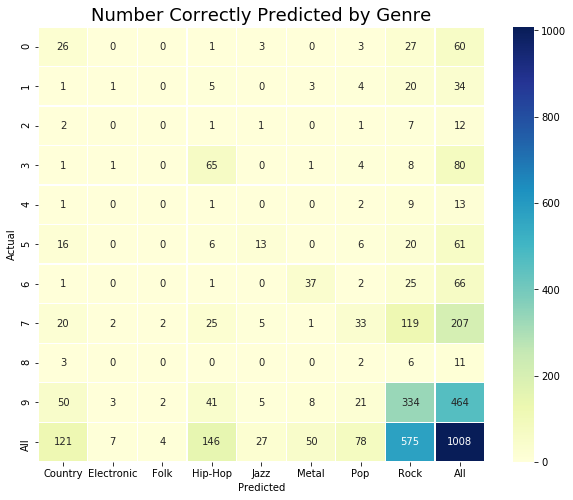

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(df_confusion, cmap="YlGnBu", annot=True, fmt="d", linewidth=0.3)
plt.title("Number Correctly Predicted by Genre", fontsize=18)

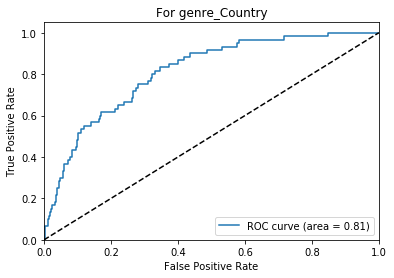

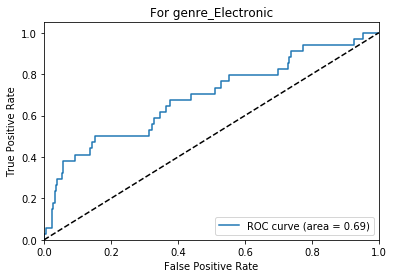

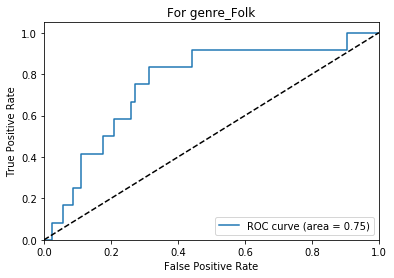

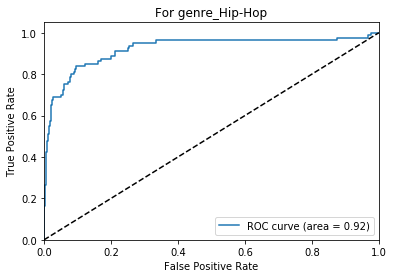

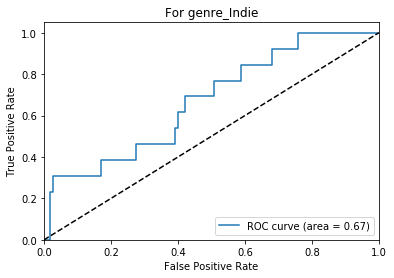

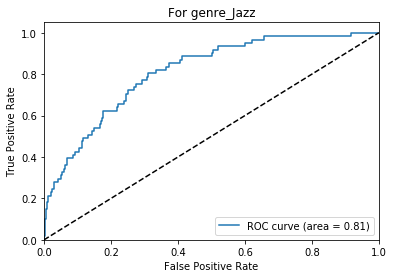

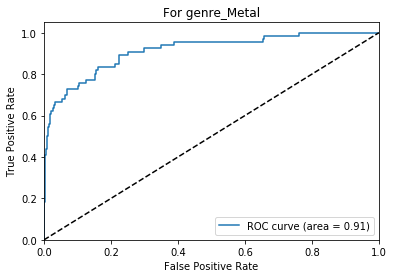

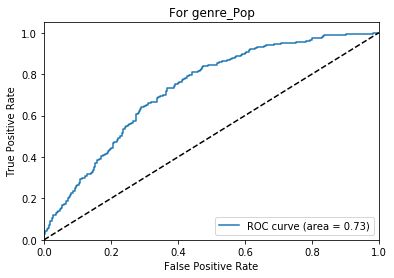

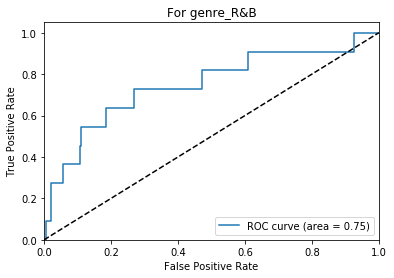

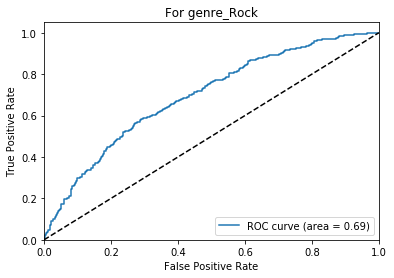

In [40]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
n_classes = 10
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i].tolist(), y_test_pred_prob[:, i].tolist())
    #fpr[i], tpr[i], thresholds = roc_curve([1]*len(y_test), [0.5]*len(y_test))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
   
    plt.figure()
    plt.title('For ' + genre_list[i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()



In [41]:
genre_list[i][6:]

'Rock'

No handles with labels found to put in legend.


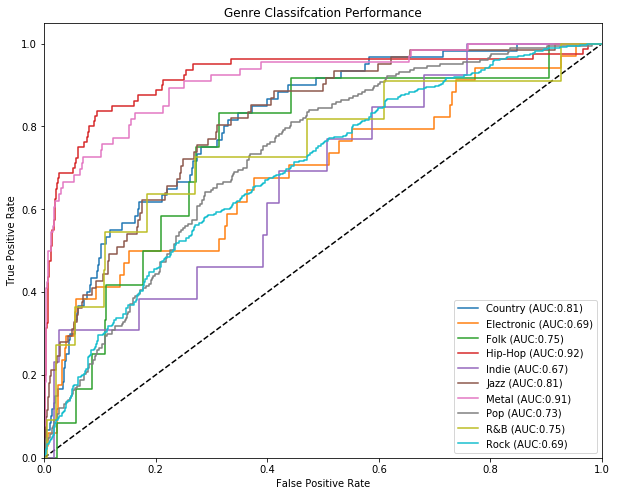

In [42]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
n_classes = 10
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
plt.title('Genre Classifcation Performance')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i].tolist(), y_test_pred_prob[:, i].tolist())
    #fpr[i], tpr[i], thresholds = roc_curve([1]*len(y_test), [0.5]*len(y_test))
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], label=genre_list[i][6:]+' (AUC:%0.2f)' % roc_auc[i])

plt.legend(loc="lower right")
plt.show()